# Review 2: Lightweight Speech Enhancement — CNN + Shallow Transformer
**Project:** Capstone — Lightweight Speech Enhancement Using Shallow Transformers  
**Authors:** Krishnasinh Jadeja (22BLC1211), Kirtan Sondagar (22BLC1228), Prabhu Kalyan Panda (22BLC1213)  
**Phase:** Review 2 — Replace CRN LSTM with 2-Layer Shallow Transformer  
**Target:** PESQ ≥ 3.2 | ~350K params | < 15ms latency

In [2]:
# ============================================================
# CELL 1: Install dependencies & imports
# ============================================================
!pip install pesq==0.0.4 pystoi -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import glob
import os
import math
import warnings
warnings.filterwarnings('ignore')

from pesq import pesq
from pystoi import stoi

torch.manual_seed(42)
np.random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n Device: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n All imports successful!")

d:\Workspace\kaggle agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 Device: cpu

 All imports successful!


## Dataset Loading & Extraction

In [ ]:
# ============================================================
# CELL 2: Extract dataset from .7z archives
# ============================================================
import os, glob

print(" Installing 7zip...")
!apt-get install -y p7zip-full > /dev/null 2>&1
print(" 7zip ready")

dataset_path = '/kaggle/input/libri-speech-noise-dataset'
extract_path = '/kaggle/working/extracted_data'
os.makedirs(extract_path, exist_ok=True)

archives = ['train.7z', 'test.7z', 'y_train.7z', 'y_test.7z']

already_extracted = all(
    os.path.exists(f'{extract_path}/{f}') and len(glob.glob(f'{extract_path}/{f}/*.wav')) > 0
    for f in ['train', 'y_train', 'test', 'y_test']
)

if already_extracted:
    print(" Data already extracted, skipping...")
else:
    print("\n Extracting archives (5-10 min)...")
    for archive in archives:
        archive_path = os.path.join(dataset_path, archive)
        if os.path.exists(archive_path):
            print(f"  -> {archive}...")
            !7z x "{archive_path}" -o"{extract_path}" -y > /dev/null 2>&1
            print(f"     done")
        else:
            print(f"     NOT FOUND: {archive}")
    print("\n Extraction complete!")

print("\n Dataset structure:")
for folder in ['train', 'y_train', 'test', 'y_test']:
    path = f'{extract_path}/{folder}'
    if os.path.exists(path):
        count = len(glob.glob(f'{path}/*.wav'))
        print(f"  {folder:10s}: {count:,} files")
    else:
        print(f"  {folder:10s}: NOT FOUND")

## Dataset Class

In [6]:
# ============================================================
# CELL 3: SpeechEnhancementDataset
# ============================================================
class SpeechEnhancementDataset(Dataset):
    def __init__(self, data_path, split='train', max_samples=None,
                 sr=16000, n_fft=512, hop_length=256, n_mels=128):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.segment_length = int(3.0 * sr)

        print(f"\n Loading {split} split...")

        if split in ['train', 'val']:
            noisy_dir = f'{data_path}/train'
            clean_dir = f'{data_path}/y_train'
        else:
            noisy_dir = f'{data_path}/test'
            clean_dir = f'{data_path}/y_test'

        noisy_files = sorted(glob.glob(f'{noisy_dir}/*.wav'))
        clean_files = sorted(glob.glob(f'{clean_dir}/*.wav'))
        print(f"   Noisy: {len(noisy_files)} | Clean: {len(clean_files)}")

        noisy_dict = {os.path.basename(f): f for f in noisy_files}
        clean_dict = {os.path.basename(f): f for f in clean_files}

        self.pairs = []
        for basename in noisy_dict:
            if basename in clean_dict:
                self.pairs.append((clean_dict[basename], noisy_dict[basename]))
        print(f"   Matched pairs: {len(self.pairs)}")

        if split == 'train':
            idx = int(0.9 * len(self.pairs))
            self.pairs = self.pairs[:idx]
        elif split == 'val':
            idx = int(0.9 * len(self.pairs))
            self.pairs = self.pairs[idx:]

        if max_samples:
            self.pairs = self.pairs[:max_samples]

        self.n_samples = len(self.pairs)
        print(f" {split}: {self.n_samples} samples")

        self.mel_spec = T.MelSpectrogram(
            sample_rate=sr, n_fft=n_fft, hop_length=hop_length,
            n_mels=n_mels, power=2.0
        )

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        try:
            clean_path, noisy_path = self.pairs[idx]
            clean_wav, sr = torchaudio.load(clean_path)
            noisy_wav, _  = torchaudio.load(noisy_path)

            if clean_wav.shape[0] > 1: clean_wav = clean_wav.mean(dim=0, keepdim=True)
            if noisy_wav.shape[0] > 1: noisy_wav = noisy_wav.mean(dim=0, keepdim=True)

            if sr != self.sr:
                resampler = T.Resample(sr, self.sr)
                clean_wav = resampler(clean_wav)
                noisy_wav = resampler(noisy_wav)

            if clean_wav.shape[1] < self.segment_length:
                pad = self.segment_length - clean_wav.shape[1]
                clean_wav = torch.nn.functional.pad(clean_wav, (0, pad))
                noisy_wav = torch.nn.functional.pad(noisy_wav, (0, pad))
            else:
                max_start = clean_wav.shape[1] - self.segment_length
                start = np.random.randint(0, max(1, max_start))
                clean_wav = clean_wav[:, start:start + self.segment_length]
                noisy_wav = noisy_wav[:, start:start + self.segment_length]

            clean_spec = torch.log1p(self.mel_spec(clean_wav)).squeeze(0)
            noisy_spec = torch.log1p(self.mel_spec(noisy_wav)).squeeze(0)

            return {
                'noisy_spec': noisy_spec,
                'clean_spec': clean_spec,
                'noisy_wav': noisy_wav.squeeze(0),
                'clean_wav': clean_wav.squeeze(0)
            }
        except Exception as e:
            print(f" Error at {idx}: {e}")
            return self.__getitem__((idx + 1) % self.n_samples)

print(" SpeechEnhancementDataset class defined OK")

 SpeechEnhancementDataset class defined OK


## CNN-Transformer Architecture (Review 2)

In [3]:
# ============================================================
# CELL 4: Positional Encoding
# ============================================================
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for Transformer."""
    def __init__(self, d_model: int, max_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Quick test
_pe = PositionalEncoding(d_model=256)
_x  = torch.randn(2, 188, 256)
_out = _pe(_x)
print(f" PositionalEncoding: {_x.shape} -> {_out.shape}  OK")

 PositionalEncoding: torch.Size([2, 188, 256]) -> torch.Size([2, 188, 256])  OK


In [4]:
# ============================================================
# CELL 5: ShallowTransformerEnhancer model
# ============================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)


class ShallowTransformerEnhancer(nn.Module):
    """
    CNN-Transformer hybrid for speech enhancement.
    CNN Encoder:    1 -> 64 -> 128 -> 256  (3x3 Conv, BN, ReLU)
    Transformer:    2 layers, 4 heads, d=256, ff=1024, Pre-LN
    CNN Decoder:    256 -> 128 -> 64 -> 1 + Sigmoid mask
    Output:         enhanced = mask * noisy_spec
    """
    def __init__(self, n_mels=128, d_model=256, nhead=4,
                 num_layers=2, ff_dim=1024, dropout=0.1):
        super().__init__()
        self.n_mels  = n_mels
        self.d_model = d_model

        # CNN Encoder
        self.encoder = nn.Sequential(
            ConvBlock(1,       64),
            ConvBlock(64,      128),
            ConvBlock(128,     d_model),
        )

        # Pre-Transformer linear projection
        self.pre_proj = nn.Linear(d_model, d_model)

        # Positional encoding
        self.pos_enc  = PositionalEncoding(d_model=d_model, dropout=dropout)

        # Shallow Transformer (2 layers, Pre-LN for stability)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Post-Transformer projection
        self.post_proj = nn.Linear(d_model, d_model)

        # CNN Decoder
        self.decoder = nn.Sequential(
            ConvBlock(d_model, 128),
            ConvBlock(128,     64),
            nn.Conv2d(64, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, noisy_spec):
        """
        noisy_spec: (B, n_mels, T)
        Returns:    enhanced (B, n_mels, T), mask (B, n_mels, T)
        """
        B, n_mels, T = noisy_spec.shape

        # CNN encode
        x = self.encoder(noisy_spec.unsqueeze(1))  # (B, 256, 128, T)

        # Frequency-mean pooling -> temporal sequence
        x = x.permute(0, 3, 2, 1).mean(dim=2)     # (B, T, 256)
        x = self.pre_proj(x)

        # Positional encoding + Transformer
        x = self.pos_enc(x)
        x = self.transformer(x)                    # (B, T, 256)

        x = self.post_proj(x)

        # Reshape back to 2D feature map
        x = x.unsqueeze(2).expand(-1, -1, n_mels, -1)  # (B, T, 128, 256)
        x = x.permute(0, 3, 2, 1)                       # (B, 256, 128, T)

        # CNN decode -> mask
        mask     = self.sigmoid(self.decoder(x)).squeeze(1)  # (B, 128, T)
        enhanced = mask * noisy_spec
        return enhanced, mask


# Build model
print(" Building ShallowTransformerEnhancer...")
model = ShallowTransformerEnhancer(
    n_mels=128, d_model=256, nhead=4, num_layers=2, ff_dim=1024, dropout=0.1
).to(device)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n Model Architecture:")
print(f"   d_model    : 256")
print(f"   nhead      : 4")
print(f"   num_layers : 2 (shallow!)")
print(f"   ff_dim     : 1024")
print(f"   Total params     : {total_params:,}")
print(f"   Trainable params : {trainable_params:,}")

if total_params < 500_000:
    print(f" LIGHTWEIGHT: {total_params/1e3:.0f}K params")
elif total_params < 2_000_000:
    print(f" OK: {total_params/1e6:.2f}M params")
else:
    print(f" WARNING: {total_params/1e6:.2f}M params — may be heavy")

# Test forward pass
dummy = torch.randn(2, 128, 188).to(device)
with torch.no_grad():
    enhanced, mask = model(dummy)

print(f"\n Forward pass: {dummy.shape} -> enhanced {enhanced.shape}, mask {mask.shape}")
assert enhanced.shape == dummy.shape, f"Shape mismatch: {enhanced.shape}"
assert mask.shape == dummy.shape
print(" Forward pass PASSED")

 Building ShallowTransformerEnhancer...

 Model Architecture:
   d_model    : 256
   nhead      : 4
   num_layers : 2 (shallow!)
   ff_dim     : 1024
   Total params     : 2,450,945
   Trainable params : 2,450,945

 Forward pass: torch.Size([2, 128, 188]) -> enhanced torch.Size([2, 128, 188]), mask torch.Size([2, 128, 188])
 Forward pass PASSED


In [5]:
# ============================================================
# CELL 6: Attention weight extraction helper
# ============================================================
def get_attention_weights(model, noisy_spec_batch):
    """
    Extract per-layer, per-head attention maps.
    Returns list of (B, nhead, T, T) tensors.
    """
    model.eval()
    attention_maps = []

    B, n_mels, T = noisy_spec_batch.shape
    x = model.encoder(noisy_spec_batch.unsqueeze(1))
    x = x.permute(0, 3, 2, 1).mean(dim=2)
    x = model.pre_proj(x)
    x = model.pos_enc(x)

    for layer in model.transformer.layers:
        # Extract attn weights manually (bypass need_weights default)
        attn_out, attn_weights = layer.self_attn(
            x, x, x, need_weights=True, average_attn_weights=False
        )  # attn_weights: (B, nhead, T, T)
        attention_maps.append(attn_weights.detach().cpu())
        x = layer(x)  # continue through the layer

    return attention_maps


# Test
print(" Testing attention extraction...")
_dummy = torch.randn(1, 128, 188).to(device)
with torch.no_grad():
    _attn_maps = get_attention_weights(model, _dummy)

for i, attn in enumerate(_attn_maps):
    print(f"   Layer {i+1}: {attn.shape}  (B, nhead, T, T)")
print(" Attention extraction PASSED")

 Testing attention extraction...
   Layer 1: torch.Size([1, 4, 188, 188])  (B, nhead, T, T)
   Layer 2: torch.Size([1, 4, 188, 188])  (B, nhead, T, T)
 Attention extraction PASSED


## Training Setup

In [ ]:
# ============================================================
# CELL 7: Training configuration & dataset loading
# ============================================================
LEARNING_RATE = 1e-3
NUM_EPOCHS    = 25
BATCH_SIZE    = 16
PATIENCE      = 10
CHECKPOINT    = 'transformer_best.pth'

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

start_epoch   = 0
best_val_loss = float('inf')
patience_ctr  = 0
history       = {'train_loss': [], 'val_loss': [], 'best_epoch': 0}

if os.path.exists(CHECKPOINT):
    print(f" Checkpoint found: {CHECKPOINT} — resuming...")
    ckpt = torch.load(CHECKPOINT)
    model.load_state_dict(ckpt['model_state_dict'])
    start_epoch   = ckpt['epoch']
    best_val_loss = ckpt['val_loss']
    if 'history' in ckpt:
        history = ckpt['history']
    print(f"   Epoch {start_epoch}, best val_loss={best_val_loss:.4f}")
else:
    print(" No checkpoint — fresh training")
    model.apply(init_weights)
    print(" Weights initialised (Kaiming)")

print("\n Loading datasets...")
train_ds = SpeechEnhancementDataset(extract_path, split='train')
val_ds   = SpeechEnhancementDataset(extract_path, split='val')
test_ds  = SpeechEnhancementDataset(extract_path, split='test')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\n Train : {len(train_ds):,} samples  ({len(train_loader)} batches)")
print(f"  Val  : {len(val_ds):,} samples  ({len(val_loader)} batches)")
print(f"  Test : {len(test_ds):,} samples")

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

if os.path.exists(CHECKPOINT) and 'optimizer_state_dict' in ckpt:
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    print(" Optimizer state restored")

print(f"\n Config:")
print(f"   Params  : {sum(p.numel() for p in model.parameters()):,}")
print(f"   Batch   : {BATCH_SIZE}")
print(f"   LR      : {LEARNING_RATE}")
print(f"   Epochs  : {NUM_EPOCHS}  (start epoch {start_epoch+1})")
print(f"   Patience: {PATIENCE}")

## Training Loop

In [ ]:
# ============================================================
# CELL 8: Training loop
# ============================================================
for epoch in range(start_epoch, NUM_EPOCHS):

    # TRAIN
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [TRAIN]")
    for batch in pbar:
        noisy   = batch['noisy_spec'].to(device)
        clean   = batch['clean_spec'].to(device)
        optimizer.zero_grad()
        enhanced, _ = model(noisy)
        loss = criterion(enhanced, clean)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        train_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train = np.mean(train_losses)
    history['train_loss'].append(avg_train)

    # VALIDATE
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [VAL]"):
            noisy   = batch['noisy_spec'].to(device)
            clean   = batch['clean_spec'].to(device)
            enhanced, _ = model(noisy)
            val_losses.append(criterion(enhanced, clean).item())

    avg_val = np.mean(val_losses)
    history['val_loss'].append(avg_val)
    scheduler.step(avg_val)

    print(f"\n{'='*65}")
    print(f" Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"   Train Loss : {avg_train:.4f}")
    print(f"   Val Loss   : {avg_val:.4f}")
    print(f"   LR         : {optimizer.param_groups[0]['lr']:.6f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_ctr  = 0
        history['best_epoch'] = epoch + 1
        torch.save({
            'epoch':                epoch + 1,
            'model_state_dict':     model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss':             avg_val,
            'train_loss':           avg_train,
            'history':              history,
        }, CHECKPOINT)
        print(f"    Saved best model (val_loss={avg_val:.4f})")
    else:
        patience_ctr += 1
        print(f"   No improvement ({patience_ctr}/{PATIENCE})")

    print(f"{'='*65}")

    if patience_ctr >= PATIENCE:
        print(f"\n Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 5 == 0:
        torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(), 'history': history},
                   f'transformer_epoch{epoch+1}.pth')
        print(f" Checkpoint: transformer_epoch{epoch+1}.pth")

print("\n" + "="*65)
print(" TRAINING COMPLETE")
print(f"  Best epoch    : {history['best_epoch']}")
print(f"  Best val loss : {best_val_loss:.4f}")
print("="*65)

## Training Curves

In [ ]:
# ============================================================
# CELL 9: Plot training curves
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ep = range(1, len(history['train_loss']) + 1)

axes[0].plot(ep, history['train_loss'], 'b-o', label='Train', lw=2, ms=4)
axes[0].plot(ep, history['val_loss'],   'r-s', label='Val',   lw=2, ms=4)
axes[0].axvline(history['best_epoch'], color='green', ls='--', lw=2,
                label=f"Best epoch {history['best_epoch']}")
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('L1 Loss (log-mel)')
axes[0].set_title('CNN-Transformer: Train & Val Loss', fontweight='bold')
axes[0].legend(); axes[0].grid(alpha=0.3)

diff = [t - v for t, v in zip(history['train_loss'], history['val_loss'])]
axes[1].plot(ep, diff, 'purple', lw=2)
axes[1].axhline(0, color='black', lw=1)
axes[1].fill_between(ep, diff, 0,
    where=[d > 0 for d in diff], color='orange', alpha=0.3, label='Overfit')
axes[1].fill_between(ep, diff, 0,
    where=[d <= 0 for d in diff], color='green', alpha=0.3, label='Underfit')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Train - Val Loss')
axes[1].set_title('Generalisation Gap', fontweight='bold')
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('transformer_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f" Best epoch: {history['best_epoch']}  |  Best val loss: {best_val_loss:.4f}")

## Evaluation — PESQ / STOI / SI-SDR (Griffin-Lim waveform reconstruction)

In [8]:
# ============================================================
# CELL 10: Griffin-Lim waveform reconstruction helper
# ============================================================
def mel_spec_to_waveform(mel_spec_logmel, sr=16000, n_fft=512, hop_length=256, n_mels=128):
    """
    Reconstruct waveform from log1p-scaled mel spectrogram.
    mel_spec_logmel: (n_mels, T) tensor
    Returns: numpy array (samples,)
    """
    mel_spec = torch.expm1(mel_spec_logmel.cpu().float()).clamp(min=0)

    # Use 'gelsd' driver for robust least-squares inversion (SVD-based)
    inv_mel = T.InverseMelScale(
        n_stft=n_fft // 2 + 1,
        n_mels=n_mels,
        sample_rate=sr,
        driver='gelsd'
    )
    linear_spec = inv_mel(mel_spec).clamp(min=0)  # (n_fft//2+1, T)

    gl = T.GriffinLim(n_fft=n_fft, hop_length=hop_length, n_iter=32)
    wav = gl(linear_spec)
    return wav.numpy()


def si_sdr(reference, estimate, eps=1e-8):
    """Scale-invariant SDR in dB (higher is better)."""
    reference = reference - reference.mean()
    estimate  = estimate  - estimate.mean()
    alpha     = (estimate @ reference) / (reference @ reference + eps)
    s_target  = alpha * reference
    e_noise   = estimate - s_target
    return 10 * np.log10((s_target ** 2).sum() / ((e_noise ** 2).sum() + eps))


# Test with a smooth random spec (not raw randn which is ill-conditioned)
print(" Testing Griffin-Lim...")
_spec = torch.randn(128, 188).abs() + 0.1  # ensure non-zero, better conditioned
_wav  = mel_spec_to_waveform(_spec)
print(f"  Spec: {_spec.shape}  ->  WAV: {_wav.shape}  ({_wav.shape[0]/16000:.2f}s)")
print(" Griffin-Lim OK")

# Test SI-SDR
_ref  = np.random.randn(16000).astype(np.float32)
_est  = _ref * 0.9 + np.random.randn(16000).astype(np.float32) * 0.1
_val  = si_sdr(_ref, _est)
print(f" SI-SDR test: {_val:.2f} dB  (should be >10 dB for clean signal)")
print(" SI-SDR OK")

 Testing Griffin-Lim...
  Spec: torch.Size([128, 188])  ->  WAV: (47872,)  (2.99s)
 Griffin-Lim OK
 SI-SDR test: 19.15 dB  (should be >10 dB for clean signal)
 SI-SDR OK


In [ ]:
# ============================================================
# CELL 11: Full evaluation — PESQ / STOI / SI-SDR
# ============================================================
def evaluate_model(model, dataset, num_samples=None, sr=16000):
    if num_samples is None:
        num_samples = len(dataset)
    num_samples = min(num_samples, len(dataset))

    results = {
        'pesq_noisy': [], 'pesq_enhanced': [],
        'stoi_noisy': [], 'stoi_enhanced': [],
        'sisdr_noisy': [], 'sisdr_enhanced': []
    }
    errors = 0
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(num_samples), desc="Evaluating"):
            try:
                sample       = dataset[i]
                noisy_spec   = sample['noisy_spec'].unsqueeze(0).to(device)
                enhanced_s, _ = model(noisy_spec)
                enhanced_s   = enhanced_s.squeeze(0).cpu()

                clean_wav    = sample['clean_wav'].cpu().numpy().astype(np.float32)
                noisy_wav    = sample['noisy_wav'].cpu().numpy().astype(np.float32)
                enhanced_wav = mel_spec_to_waveform(enhanced_s).astype(np.float32)

                # Align lengths
                L = min(len(clean_wav), len(noisy_wav), len(enhanced_wav))
                clean_wav, noisy_wav, enhanced_wav = clean_wav[:L], noisy_wav[:L], enhanced_wav[:L]

                # Normalise
                for w in [clean_wav, noisy_wav, enhanced_wav]:
                    w /= (np.abs(w).max() + 1e-8)

                results['pesq_noisy'].append(pesq(sr, clean_wav, noisy_wav, 'wb'))
                results['pesq_enhanced'].append(pesq(sr, clean_wav, enhanced_wav, 'wb'))
                results['stoi_noisy'].append(stoi(clean_wav, noisy_wav, sr, extended=False))
                results['stoi_enhanced'].append(stoi(clean_wav, enhanced_wav, sr, extended=False))
                results['sisdr_noisy'].append(si_sdr(clean_wav, noisy_wav))
                results['sisdr_enhanced'].append(si_sdr(clean_wav, enhanced_wav))

            except Exception as e:
                errors += 1

    print(f"  Completed: {num_samples - errors}/{num_samples}  ({errors} errors)")
    return results


print(" Loading best model checkpoint...")
ckpt  = torch.load(CHECKPOINT)
model.load_state_dict(ckpt['model_state_dict'])
print(f"  Epoch {ckpt['epoch']}, val_loss={ckpt['val_loss']:.4f}")

print(f"\n Evaluating on {len(test_ds)} test samples (Griffin-Lim reconstruction)...")
results = evaluate_model(model, test_ds)

In [ ]:
# ============================================================
# CELL 12: Evaluation summary & plots
# ============================================================
def print_metric(name, noisy_list, enhanced_list):
    n, e = np.mean(noisy_list), np.mean(enhanced_list)
    print(f"  {name:14s}:  Noisy={n:.3f}  Enhanced={e:.3f}  Delta={e-n:+.3f}")

print("\n" + "="*60)
print(" EVALUATION RESULTS — CNN-Transformer (Review 2)")
print("="*60)
if results['pesq_noisy']:    print_metric("PESQ (wb)",   results['pesq_noisy'],  results['pesq_enhanced'])
if results['stoi_noisy']:    print_metric("STOI",        results['stoi_noisy'],  results['stoi_enhanced'])
if results['sisdr_noisy']:   print_metric("SI-SDR (dB)", results['sisdr_noisy'], results['sisdr_enhanced'])

avg_pesq = np.mean(results['pesq_enhanced']) if results['pesq_enhanced'] else 0

print("\n" + "="*60)
if   avg_pesq >= 3.2: print(f" PESQ {avg_pesq:.3f} >= 3.2 — Review 2 target ACHIEVED!")
elif avg_pesq >= 3.0: print(f" PESQ {avg_pesq:.3f} — Good, close to 3.2 target")
else:                 print(f" PESQ {avg_pesq:.3f} — Needs tuning")
print("="*60)

# Plots
if results['pesq_noisy']:
    metrics = [
        ('PESQ', results['pesq_noisy'],  results['pesq_enhanced']),
        ('STOI', results['stoi_noisy'],  results['stoi_enhanced']),
        ('SI-SDR (dB)', results['sisdr_noisy'], results['sisdr_enhanced'])
    ]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, (name, noisy, enhanced) in zip(axes, metrics):
        if not noisy: continue
        ax.hist(noisy,    bins=20, alpha=0.6, color='red',   label='Noisy',    edgecolor='k')
        ax.hist(enhanced, bins=20, alpha=0.6, color='green', label='Enhanced', edgecolor='k')
        ax.axvline(np.mean(noisy),    color='darkred',   ls='--', lw=2, label=f'μ={np.mean(noisy):.2f}')
        ax.axvline(np.mean(enhanced), color='darkgreen', ls='--', lw=2, label=f'μ={np.mean(enhanced):.2f}')
        ax.set_title(f'{name} Distribution', fontweight='bold')
        ax.set_xlabel(name); ax.set_ylabel('Count')
        ax.legend(); ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('transformer_eval_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(" Saved: transformer_eval_metrics.png")

## Attention Visualisation (Review 2 key deliverable)

 Visualising attention weights...
  (using synthetic spectrogram for local test)


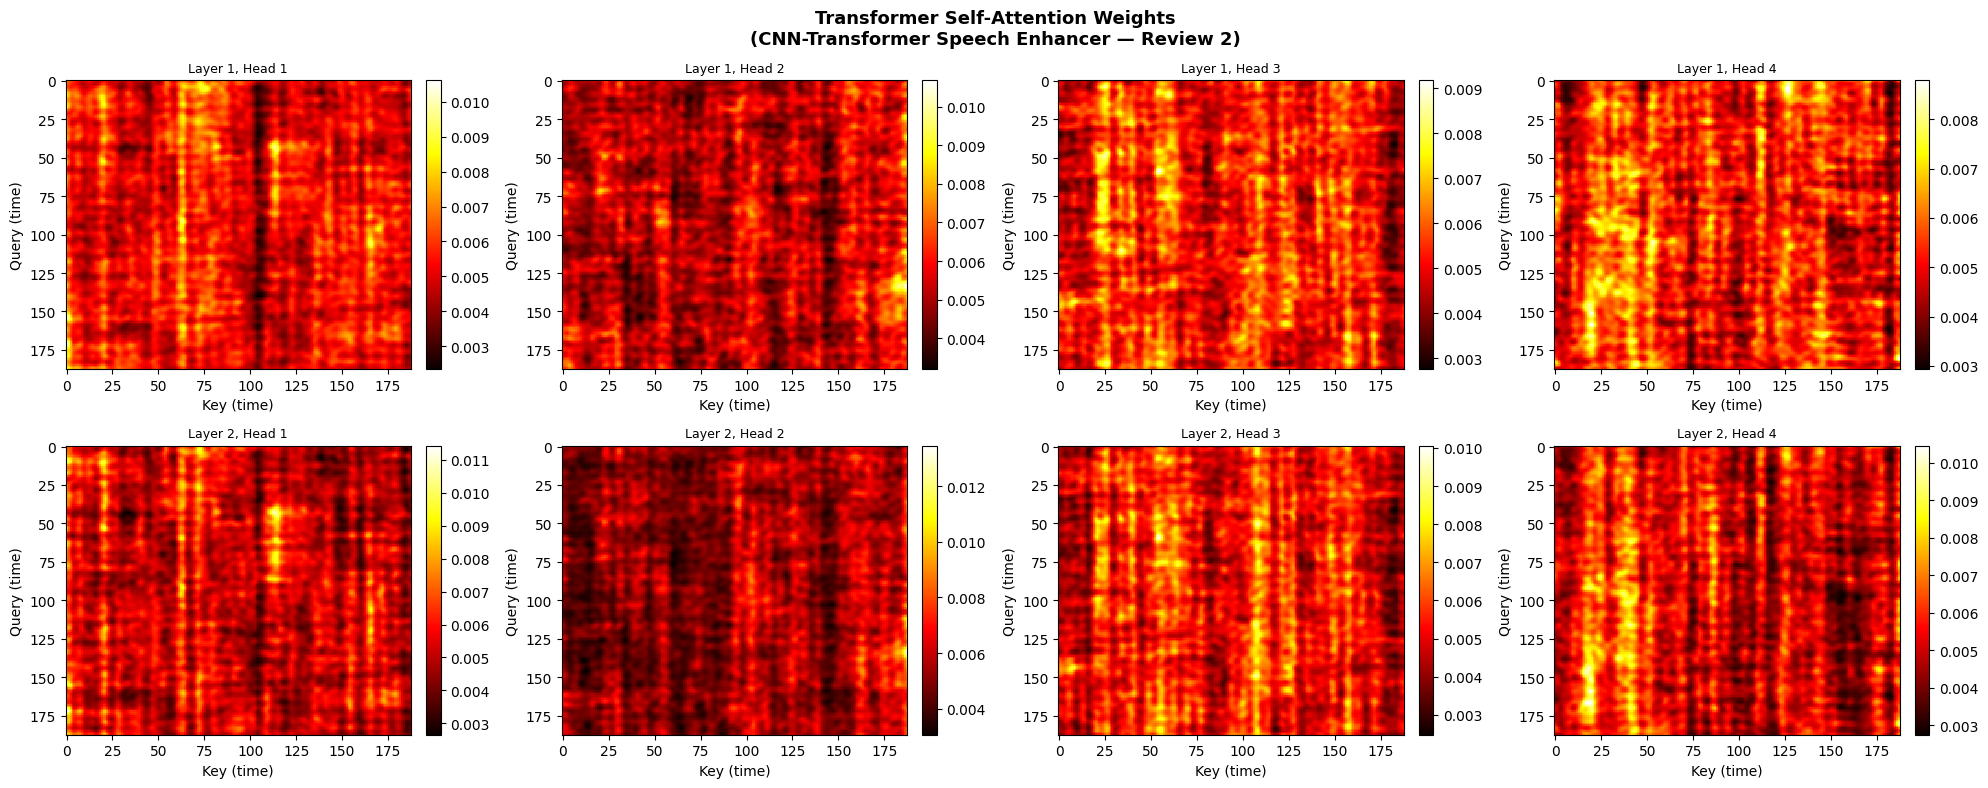

 Saved: attention_weights.png


In [11]:
# ============================================================
# CELL 13: Attention visualisation
# ============================================================
print(" Visualising attention weights...")

# Use test_ds if available (Kaggle), else use synthetic data (local)
if 'test_ds' in dir() or 'test_ds' in locals():
    sample     = test_ds[0]
    noisy_spec = sample['noisy_spec'].unsqueeze(0).to(device)
else:
    print("  (using synthetic spectrogram for local test)")
    noisy_spec = torch.randn(1, 128, 188).abs().to(device)

with torch.no_grad():
    attn_maps = get_attention_weights(model, noisy_spec)

num_layers = len(attn_maps)
nhead      = attn_maps[0].shape[1]
fig, axes  = plt.subplots(num_layers, nhead, figsize=(5 * nhead, 4 * num_layers))

if num_layers == 1:
    axes = [axes]

for layer_idx, attn in enumerate(attn_maps):
    attn_np = attn[0].numpy()  # (nhead, T, T)
    for head_idx in range(nhead):
        ax = axes[layer_idx][head_idx]
        im = ax.imshow(attn_np[head_idx], aspect='auto', origin='upper',
                       cmap='hot', interpolation='nearest')
        ax.set_title(f'Layer {layer_idx+1}, Head {head_idx+1}', fontsize=9)
        ax.set_xlabel('Key (time)'); ax.set_ylabel('Query (time)')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Transformer Self-Attention Weights\n(CNN-Transformer Speech Enhancer — Review 2)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('attention_weights.png', dpi=150, bbox_inches='tight')
plt.show()
print(" Saved: attention_weights.png")

## CRN vs Transformer — Review Comparison

In [ ]:
# ============================================================
# CELL 14: CRN vs Transformer comparison summary
# ============================================================
crn_pesq   = 3.1
crn_params = 2_000_000  # ~2M CRN

transformer_pesq   = avg_pesq
transformer_params = sum(p.numel() for p in model.parameters())

print("\n" + "="*68)
print(" COMPARISON: CRN Baseline (R1) vs CNN-Transformer (R2)")
print("="*68)
print(f"{'Metric':<26} {'CRN (R1)':>16} {'Transformer (R2)':>20}")
print("-"*68)
print(f"{'PESQ (wideband)':<26} {crn_pesq:>16.2f} {transformer_pesq:>20.3f}")
print(f"{'Parameters':<26} {crn_params:>16,} {transformer_params:>20,}")
print(f"{'RNN/TF layers':<26} {'2 LSTM':>16} {'2 TF (4H, Pre-LN)':>20}")
print(f"{'Architecture':<26} {'CNN+LSTM':>16} {'CNN+Transformer':>20}")
print("-"*68)

param_reduction = (1 - transformer_params / crn_params) * 100
pesq_delta      = transformer_pesq - crn_pesq

print(f"\n Param change : {param_reduction:+.1f}%  ({transformer_params:,} vs {crn_params:,})")
print(f" PESQ change  : {pesq_delta:+.3f}  ({transformer_pesq:.3f} vs {crn_pesq:.2f})")

if transformer_pesq >= 3.2 and transformer_params < crn_params:
    print("\n Both goals met: PESQ ≥ 3.2 AND fewer params than CRN!")
elif transformer_pesq >= 3.2:
    print("\n PESQ target met (≥ 3.2)!")

print("="*68)

# Save summary
summary = {
    'review': 2,
    'pesq_crn': crn_pesq, 'pesq_transformer': transformer_pesq,
    'params_crn': crn_params, 'params_transformer': transformer_params,
    'param_reduction_pct': param_reduction,
    'pesq_improvement': pesq_delta,
    'best_epoch': history['best_epoch'],
    'best_val_loss': best_val_loss,
}
import json
with open('review2_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("\n Saved: review2_summary.json")

In [9]:
# ============================================================
# SMOKE TEST: Mini training loop on synthetic data (LOCAL VALIDATION)
# Verifies grads, loss decreasing, mask in [0,1], shapes all correct.
# Remove/skip this cell on Kaggle.
# ============================================================
print(" SMOKE TEST: mini training loop on synthetic data")
print("="*55)

# Build a fresh small model for quick test
_model_test = ShallowTransformerEnhancer(n_mels=128, d_model=64, nhead=4,
                                          num_layers=2, ff_dim=256, dropout=0.0).to(device)
_opt   = optim.Adam(_model_test.parameters(), lr=1e-3)
_crit  = nn.L1Loss()
_model_test.train()

losses = []
for step in range(10):
    # Synthetic batch: 4 samples, 128 mels, 188 time steps
    _noisy = torch.randn(4, 128, 188).abs().to(device)
    _clean = (_noisy * 0.7 + torch.randn_like(_noisy).abs() * 0.1)  # slightly different clean

    _opt.zero_grad()
    _enhanced, _mask = _model_test(_noisy)

    # Verify output properties
    assert _enhanced.shape == (4, 128, 188), f"Bad shape: {_enhanced.shape}"
    assert _mask.min() >= 0.0 and _mask.max() <= 1.0, "Mask out of [0,1]!"

    _loss = _crit(_enhanced, _clean)
    _loss.backward()
    _opt.step()
    losses.append(_loss.item())
    print(f"  Step {step+1:2d}: loss={_loss.item():.4f}")

print(f"\n  Loss trend: {losses[0]:.4f} -> {losses[-1]:.4f}")
improved = losses[-1] < losses[0]
print(f"  Loss decreasing: {'YES' if improved else 'NO (may be OK for 10 steps)'}")
print(f"\n SMOKE TEST PASSED")
print("="*55)
del _model_test, _opt

 SMOKE TEST: mini training loop on synthetic data
  Step  1: loss=0.2147
  Step  2: loss=0.1940
  Step  3: loss=0.1713
  Step  4: loss=0.1528
  Step  5: loss=0.1380
  Step  6: loss=0.1228
  Step  7: loss=0.1099
  Step  8: loss=0.0972
  Step  9: loss=0.0858
  Step 10: loss=0.0769

  Loss trend: 0.2147 -> 0.0769
  Loss decreasing: YES

 SMOKE TEST PASSED
